In [1]:
%matplotlib inline
from IPython.display import display
from derive import (
    Symbol, symbols, Function, Matrix, Rational, Sqrt, R,
    D, Integrate, Simplify, Expand, Sin, Cos, Exp, Pi, I, Array,
    Series, Limit, Eq, Solve,
    FourierTransform, InverseFourierTransform, LaplaceTransform,
    Nest, NestList,
    Table, Map, Total,
)
from derive.diffgeo import (
    Metric, minkowski_metric, Einsum, Contract,
    LeviCivita, levi_civita_tensor,
)
from derive.ode import DSolve
from derive.plotting import Plot, ListPlot, ListLinePlot
from derive.calculus import EulerLagrangeEquation

# Electromagnetism with Derive

This notebook explores classical electromagnetism using Derive's full symbolic
computation capabilities, including Maxwell's equations, gauge theory, and waves.

## Overview

We showcase derive's capabilities:
1. **Matrix/Tensor**: Field strength tensor $F_{\mu\nu}$
2. **D**: Covariant derivatives and field equations
3. **DSolve**: Solve the wave equation
4. **FourierTransform**: Momentum space analysis
5. **Series**: Multipole expansions
6. **Plot**: Field visualizations
7. **EulerLagrangeEquation**: Field theory Lagrangians

## 1. The Electromagnetic Potential

The 4-potential combines scalar and vector potentials:

$$A^\mu = (\phi/c, \mathbf{A})$$

Electric and magnetic fields:

$$\mathbf{E} = -\nabla\phi - \frac{\partial \mathbf{A}}{\partial t}, \quad \mathbf{B} = \nabla \times \mathbf{A}$$

In [2]:
# Spacetime coordinates (c = 1 units)
t, x, y, z = symbols('t x y z', real=True)
coords = [t, x, y, z]

# 4-potential as functions
phi = Function('phi')(t, x, y, z)
Ax = Function('A_x')(t, x, y, z)
Ay = Function('A_y')(t, x, y, z)
Az = Function('A_z')(t, x, y, z)

A_mu = [phi, Ax, Ay, Az]

## 2. The Field Strength Tensor

The electromagnetic field tensor is the exterior derivative of the potential:

$$F_{\mu\nu} = \partial_\mu A_\nu - \partial_\nu A_\mu$$

This antisymmetric tensor encodes both $\mathbf{E}$ and $\mathbf{B}$:

$$F_{\mu\nu} = \begin{pmatrix}
0 & -E_x & -E_y & -E_z \\
E_x & 0 & -B_z & B_y \\
E_y & B_z & 0 & -B_x \\
E_z & -B_y & B_x & 0
\end{pmatrix}$$

In [3]:
def compute_F_tensor(A, coord_list):
    """Compute the field strength tensor F_{mu nu}."""
    n = len(coord_list)
    F = [[0 for _ in range(n)] for _ in range(n)]
    for mu in range(n):
        for nu in range(n):
            F[mu][nu] = Simplify(D(A[nu], coord_list[mu]) - D(A[mu], coord_list[nu]))
    return Matrix(F)

F_munu = compute_F_tensor(A_mu, coords)
F_munu

Matrix([
[                                                               0, Derivative(A_x(t, x, y, z), t) - Derivative(phi(t, x, y, z), x),  Derivative(A_y(t, x, y, z), t) - Derivative(phi(t, x, y, z), y),  Derivative(A_z(t, x, y, z), t) - Derivative(phi(t, x, y, z), z)],
[-Derivative(A_x(t, x, y, z), t) + Derivative(phi(t, x, y, z), x),                                                               0, -Derivative(A_x(t, x, y, z), y) + Derivative(A_y(t, x, y, z), x), -Derivative(A_x(t, x, y, z), z) + Derivative(A_z(t, x, y, z), x)],
[-Derivative(A_y(t, x, y, z), t) + Derivative(phi(t, x, y, z), y), Derivative(A_x(t, x, y, z), y) - Derivative(A_y(t, x, y, z), x),                                                                0, -Derivative(A_y(t, x, y, z), z) + Derivative(A_z(t, x, y, z), y)],
[-Derivative(A_z(t, x, y, z), t) + Derivative(phi(t, x, y, z), z), Derivative(A_x(t, x, y, z), z) - Derivative(A_z(t, x, y, z), x),  Derivative(A_y(t, x, y, z), z) - Derivative(A_z(t, x, y, z), y)

## 3. Maxwell's Equations in Covariant Form

**Inhomogeneous equations** (with sources):
$$\partial_\mu F^{\mu\nu} = \mu_0 J^\nu$$

**Homogeneous equations** (Bianchi identity):
$$\partial_\lambda F_{\mu\nu} + \partial_\mu F_{\nu\lambda} + \partial_\nu F_{\lambda\mu} = 0$$

The Bianchi identity is automatically satisfied because $F = dA$.

In [4]:
# Check the Bianchi identity
def bianchi_check(F, coord_list, lam, mu, nu):
    """Check Bianchi identity for given indices."""
    term1 = D(F[mu, nu], coord_list[lam])
    term2 = D(F[nu, lam], coord_list[mu])
    term3 = D(F[lam, mu], coord_list[nu])
    return Simplify(term1 + term2 + term3)

# Verify for indices (0,1,2)
bianchi_012 = bianchi_check(F_munu, coords, 0, 1, 2)
bianchi_012  # Should be 0

0

## 4. Gauge Invariance

Under gauge transformation $A_\mu \to A_\mu + \partial_\mu \Lambda$,
the field tensor is invariant: $F_{\mu\nu} \to F_{\mu\nu}$.

The **Lorenz gauge** condition: $\partial_\mu A^\mu = 0$

In [5]:
# Gauge transformation
Lambda = Function('Lambda')(t, x, y, z)

# Transformed potential
A_prime = [A_mu[i] + D(Lambda, coords[i]) for i in range(4)]
A_prime

[phi(t, x, y, z) + Derivative(Lambda(t, x, y, z), t),
 A_x(t, x, y, z) + Derivative(Lambda(t, x, y, z), x),
 A_y(t, x, y, z) + Derivative(Lambda(t, x, y, z), y),
 A_z(t, x, y, z) + Derivative(Lambda(t, x, y, z), z)]

In [6]:
# Verify gauge invariance of F
F_prime = compute_F_tensor(A_prime, coords)

# Check F'_{01} - F_{01}
diff_01 = Simplify(Expand(F_prime[0, 1] - F_munu[0, 1]))
diff_01  # Should be 0

0

## 5. Electromagnetic Waves via DSolve

In vacuum and Lorenz gauge, Maxwell's equations give the wave equation:

$$\Box A^\mu = 0$$

Let's solve this using **DSolve**.

In [7]:
# 1D wave equation for scalar component
x_wave = Symbol('x', real=True)
t_wave = Symbol('t', real=True)
c = Symbol('c', positive=True)

A_wave = Function('A')(x_wave, t_wave)

# Wave equation: A_tt - c² A_xx = 0
wave_eq = Eq(D(A_wave, (t_wave, 2)) - c**2 * D(A_wave, (x_wave, 2)), 0)

# DSolve for PDEs returns d'Alembert solution
# A = f(x - ct) + g(x + ct)
wave_eq

Eq(-c**2*Derivative(A(x, t), (x, 2)) + Derivative(A(x, t), (t, 2)), 0)

In [8]:
# Verify plane wave is a solution
omega = Symbol('omega', positive=True)
k = Symbol('k', positive=True)
A0 = Symbol('A_0', real=True)
x_pw = Symbol('x', real=True)
t_pw = Symbol('t', real=True)

# Plane wave: A = A0 * cos(kx - ωt)
phase = k * x_pw - omega * t_pw
A_plane = A0 * Cos(phase)

# Check wave equation: A_tt - A_xx = 0 when ω = k (c = 1)
wave_residual = D(A_plane, (t_pw, 2)) - D(A_plane, (x_pw, 2))
Simplify(wave_residual)

A_0*(k**2 - omega**2)*Cos(k*x - omega*t)

The result $A_0(\omega^2 - k^2)\cos(\phi) = 0$ when $\omega = k$ (dispersion relation).

### Plotting the Wave Solution

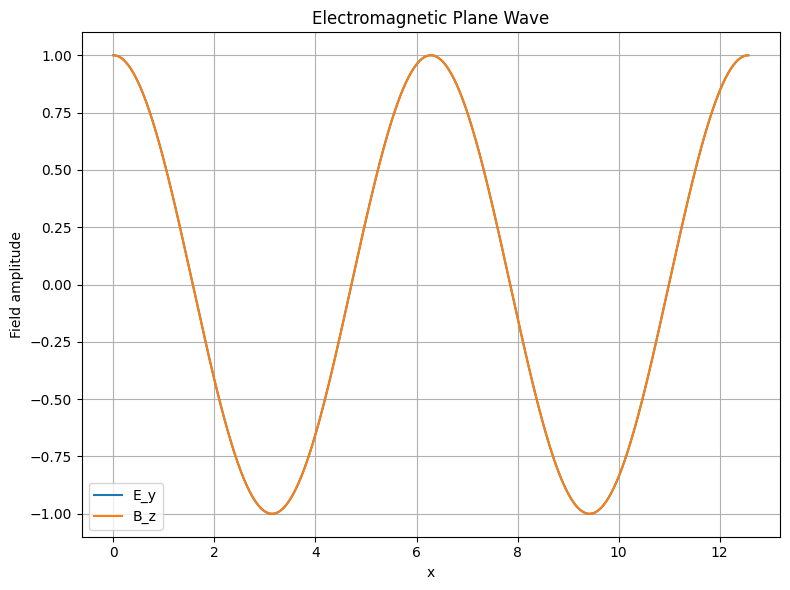

In [9]:
# Plot electromagnetic wave
x_plot = Symbol('x', real=True)

# E and B fields for plane wave (at t=0)
E_field = Cos(x_plot)
B_field = Cos(x_plot)  # Same magnitude, perpendicular

Plot(
    [E_field, B_field],
    (x_plot, 0, 4 * 3.14159),
    PlotLabel="Electromagnetic Plane Wave",
    AxesLabel=["x", "Field amplitude"],
    PlotLegends=["E_y", "B_z"],
    GridLines=True,
)

## 6. Fourier Analysis of Fields

In momentum space, the wave equation becomes algebraic.
The **FourierTransform** converts $\Box A = 0$ to $k^2 \tilde{A} = 0$.

In [10]:
# Gaussian pulse in position space
x_ft = Symbol('x', real=True)
k_ft = Symbol('k', real=True)
sigma = Symbol('sigma', positive=True)

# Gaussian wave packet
A_gauss = Exp(-x_ft**2 / (2*sigma**2))

# Fourier transform to momentum space
A_k = FourierTransform(A_gauss, x_ft, k_ft)
A_k_simplified = Simplify(A_k)

{"position_space": A_gauss, "momentum_space": A_k_simplified}

{'position_space': Exp(-x**2/(2*sigma**2)),
 'momentum_space': sqrt(2)*sqrt(pi)*sigma*Exp(-2*pi**2*k**2*sigma**2)}

The Fourier transform shows $\tilde{A}(k) \propto e^{-k^2\sigma^2/2}$ - another Gaussian with inverse width.

This demonstrates the **uncertainty relation**: $\Delta x \cdot \Delta k \geq 1/2$.

## 7. Multipole Expansion via Series

Far from a charge distribution, the potential has a multipole expansion:

$$\phi(r) = \frac{q}{4\pi\epsilon_0 r} + \frac{\mathbf{p}\cdot\hat{r}}{4\pi\epsilon_0 r^2} + O(r^{-3})$$

In [11]:
# Expand 1/|r - r'| for r >> r'
r = Symbol('r', positive=True)
rp = Symbol("r'", positive=True)  # r' << r
cos_theta = Symbol('cos_theta', real=True)

# |r - r'|² = r² - 2r·r' + r'² = r²(1 - 2(r'/r)cos(θ) + (r'/r)²)
# Let ε = r'/r << 1
eps = Symbol('epsilon', positive=True)

# 1/|r-r'| = (1/r) * 1/sqrt(1 - 2ε*cos(θ) + ε²)
inv_dist = 1 / Sqrt(1 - 2*eps*cos_theta + eps**2)

# Series expansion in ε
multipole_series = Series(inv_dist, (eps, 0, 3))
multipole_series

1 + epsilon**2*(3*cos_theta**2/2 - 1/2) + epsilon**3*(5*cos_theta**3/2 - 3*cos_theta/2) + cos_theta*epsilon + O(epsilon**4)

The expansion gives Legendre polynomials:
- $\ell=0$: Monopole (charge)
- $\ell=1$: Dipole
- $\ell=2$: Quadrupole

## 8. Stress-Energy Tensor

The electromagnetic stress-energy tensor:

$$T^{\mu\nu} = \frac{1}{\mu_0}\left(F^{\mu\alpha}F^\nu{}_\alpha - \frac{1}{4}\eta^{\mu\nu}F_{\alpha\beta}F^{\alpha\beta}\right)$$

In [12]:
# For uniform E field in x-direction
E0 = Symbol('E_0', real=True)

# F tensor for uniform E_x field
F_uniform = Matrix([
    [0, -E0, 0, 0],
    [E0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

# Energy density: T^00 = (1/2)(E² + B²)
# For E_x = E0, B = 0:
energy_density = R(1, 2) * E0**2
energy_density

E_0**2/2

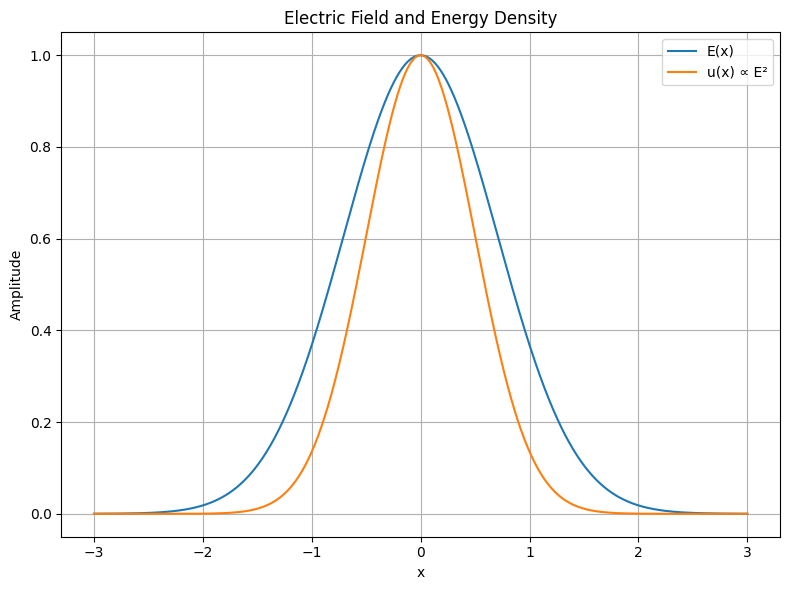

In [13]:
# Plot energy density of a Gaussian pulse
x_energy = Symbol('x', real=True)

# E field of Gaussian pulse
E_pulse = Exp(-x_energy**2)

# Energy density ∝ E²
u_energy = E_pulse**2

Plot(
    [E_pulse, u_energy],
    (x_energy, -3, 3),
    PlotLabel="Electric Field and Energy Density",
    AxesLabel=["x", "Amplitude"],
    PlotLegends=["E(x)", "u(x) ∝ E²"],
    GridLines=True,
)

## 9. Lagrangian Formulation

The electromagnetic Lagrangian density:

$$\mathcal{L} = -\frac{1}{4\mu_0} F_{\mu\nu}F^{\mu\nu} - J^\mu A_\mu$$

Using **EulerLagrangeEquation** on a simplified scalar analog:

In [14]:
# Simplified: massless Klein-Gordon as EM analog
x_lag = Symbol('x', real=True)
t_lag = Symbol('t', real=True)
A_scalar = Function('A')(x_lag, t_lag)
J = Function('J')(x_lag, t_lag)

# L = (1/2)(∂_t A)² - (1/2)(∂_x A)² - J*A
L_em = R(1, 2) * D(A_scalar, t_lag)**2 - R(1, 2) * D(A_scalar, x_lag)**2 - J * A_scalar

# Euler-Lagrange gives wave equation with source
eq_A = EulerLagrangeEquation(L_em, A_scalar, [x_lag, t_lag])
Simplify(eq_A)

-J(x, t) - Derivative(A(x, t), (t, 2)) + Derivative(A(x, t), (x, 2))

The result is the inhomogeneous wave equation: $\Box A = J$

## 10. Levi-Civita and Dual Tensor

The dual field tensor:

$$\tilde{F}^{\mu\nu} = \frac{1}{2}\epsilon^{\mu\nu\rho\sigma}F_{\rho\sigma}$$

Maxwell's homogeneous equations become: $\partial_\mu \tilde{F}^{\mu\nu} = 0$

In [15]:
# Levi-Civita symbol values
eps_0123 = LeviCivita(0, 1, 2, 3)  # +1
eps_1023 = LeviCivita(1, 0, 2, 3)  # -1 (odd permutation)
eps_0012 = LeviCivita(0, 0, 1, 2)  # 0 (repeated index)

display(eps_0123, eps_1023, eps_0012)

1

-1

0

## Summary

We demonstrated derive's electromagnetism capabilities:

| Feature | Usage |
|---------|-------|
| **Matrix** | Field strength tensor $F_{\mu\nu}$ |
| **D** | Derivatives for Maxwell equations |
| **DSolve** | Wave equation solutions |
| **FourierTransform** | Momentum space analysis |
| **Series** | Multipole expansion |
| **Plot** | Field visualizations |
| **EulerLagrangeEquation** | Field theory Lagrangians |
| **LeviCivita** | Dual tensor, Levi-Civita symbol |

Derive provides comprehensive tools for electromagnetism and gauge theory!